In [1]:
% pylab inline
#%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Reading & Checking Dataset from Pickle File

Data cleaning and compiling was done in previous ***jupyter nb***, final dataframe was pickled. 
For training and validation, the 'psr_data_trainval.pkl' is compiled by countries that are not included in the final test. The purpose of this separation is to include countries in the test set that would be representative of psr values (high, medium and low country psr scores).

Feature engineering was applied on certain features, inlcuding 'y' value and added as new columns onto psr_data. 
No missing values are present.

In [2]:
psr_data = pd.read_pickle("psr_data_trainval.pkl")

In [3]:
psr_data['fertility_log'] = np.log(psr_data.fertility)
psr_data['death_rate2'] = psr_data.death_rate ** 2
psr_data['psr_log'] = np.log(psr_data.psr)
psr_data['death_birth_ratio'] =  psr_data.death_rate/psr_data.birth_rate

In [4]:
psr_data.head()

psr  fertility  birth_rate  death_rate  life_expectancy  \
Albania 2000  8.422533       2.38        2.38       5.925             74.7   
        2001  7.988096       2.29        2.29       5.892             75.1   
        2002  7.548263       2.20        2.20       5.907             75.5   
        2003  7.113599       2.10        2.10       5.973             75.7   
        2004  6.700764       2.00        2.00       6.086             75.9   

                   gdp  fertility_log  death_rate2   psr_log  \
Albania 2000  7.348639       0.867100    35.105625  2.130911   
        2001  8.958088       0.828552    34.715664  2.077952   
        2002  4.544406       0.788457    34.892649  2.021317   
        2003  6.169982       0.741937    35.676729  1.962008   
        2004  6.152274       0.693147    37.039396  1.902222   

              death_birth_ratio  
Albania 2000           2.489496  
        2001           2.572926  
        2002           2.685000  
        2003           2.844286  
        2004           3.043000

In [5]:
psr_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2080 entries, (Albania, 2000) to (Zimbabwe, 2015)
Data columns (total 10 columns):
psr                  2080 non-null float64
fertility            2080 non-null float64
birth_rate           2080 non-null float64
death_rate           2080 non-null float64
life_expectancy      2080 non-null float64
gdp                  2080 non-null float64
fertility_log        2080 non-null float64
death_rate2          2080 non-null float64
psr_log              2080 non-null float64
death_birth_ratio    2080 non-null float64
dtypes: float64(10)
memory usage: 181.2+ KB


### Analyzing Database, Generating Correlations & Plotting

While analyzing dataset, it was discovered that birth_rate is perfectly correlated with fertility, thus birth_rate is dropped from the dataset.

In [6]:
psr_data.describe()

,psr,fertility,birth_rate,death_rate,life_expectancy,gdp,fertility_log,death_rate2,psr_log,death_birth_ratio
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,13.547214,2.940764,2.940764,8.582256,69.742740,2.713718,0.953982,84.032526,2.251024,3.645567
std,11.027668,1.542482,1.542482,3.222174,8.948906,5.529561,0.490326,65.572907,0.866317,2.296834
min,2.609576,1.130000,1.130000,3.377000,32.200000,-62.225087,0.122218,11.404129,0.959188,0.820312
25%,4.052742,1.750000,1.750000,6.130250,63.600000,0.609120,0.559616,37.579974,1.399394,2.012194
50%,9.054307,2.370000,2.370000,7.763000,72.200000,2.628475,0.862890,60.264185,2.203240,2.845596
75%,22.123715,3.950000,3.950000,10.226750,76.325000,4.824000,1.373716,104.586458,3.096650,4.532147
max,47.159055,7.730000,7.730000,19.622000,83.300000,122.968301,2.045109,385.022884,3.853526,13.566284


In [7]:
psr_data.corr()

,psr,fertility,birth_rate,death_rate,life_expectancy,gdp,fertility_log,death_rate2,psr_log,death_birth_ratio
psr,1.000000,0.963710,0.963710,0.292886,-0.801727,-0.085271,0.946017,0.318145,0.946404,-0.596686
fertility,0.963710,1.000000,1.000000,0.346294,-0.782017,-0.103550,0.975679,0.372646,0.910117,-0.603905
birth_rate,0.963710,1.000000,1.000000,0.346294,-0.782017,-0.103550,0.975679,0.372646,0.910117,-0.603905
death_rate,0.292886,0.346294,0.346294,1.000000,-0.583173,-0.010586,0.218083,0.982604,0.106306,0.461940
life_expectancy,-0.801727,-0.782017,-0.782017,-0.583173,1.000000,0.033873,-0.767515,-0.596126,-0.788146,0.298376
gdp,-0.085271,-0.103550,-0.103550,-0.010586,0.033873,1.000000,-0.113154,-0.016999,-0.069300,0.103882
fertility_log,0.946017,0.975679,0.975679,0.218083,-0.767515,-0.113154,1.000000,0.250928,0.952116,-0.718355
death_rate2,0.318145,0.372646,0.372646,0.982604,-0.596126,-0.016999,0.250928,1.000000,0.148324,0.410638
psr_log,0.946404,0.910117,0.910117,0.106306,-0.788146,-0.069300,0.952116,0.148324,1.000000,-0.747135
death_birth_ratio,-0.596686,-0.603905,-0.603905,0.461940,0.298376,0.103882,-0.718355,0.410638,-0.747135,1.000000


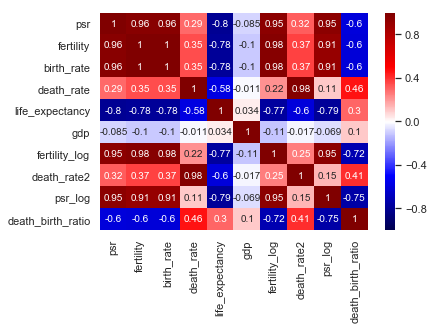

In [8]:
sns.heatmap(psr_data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

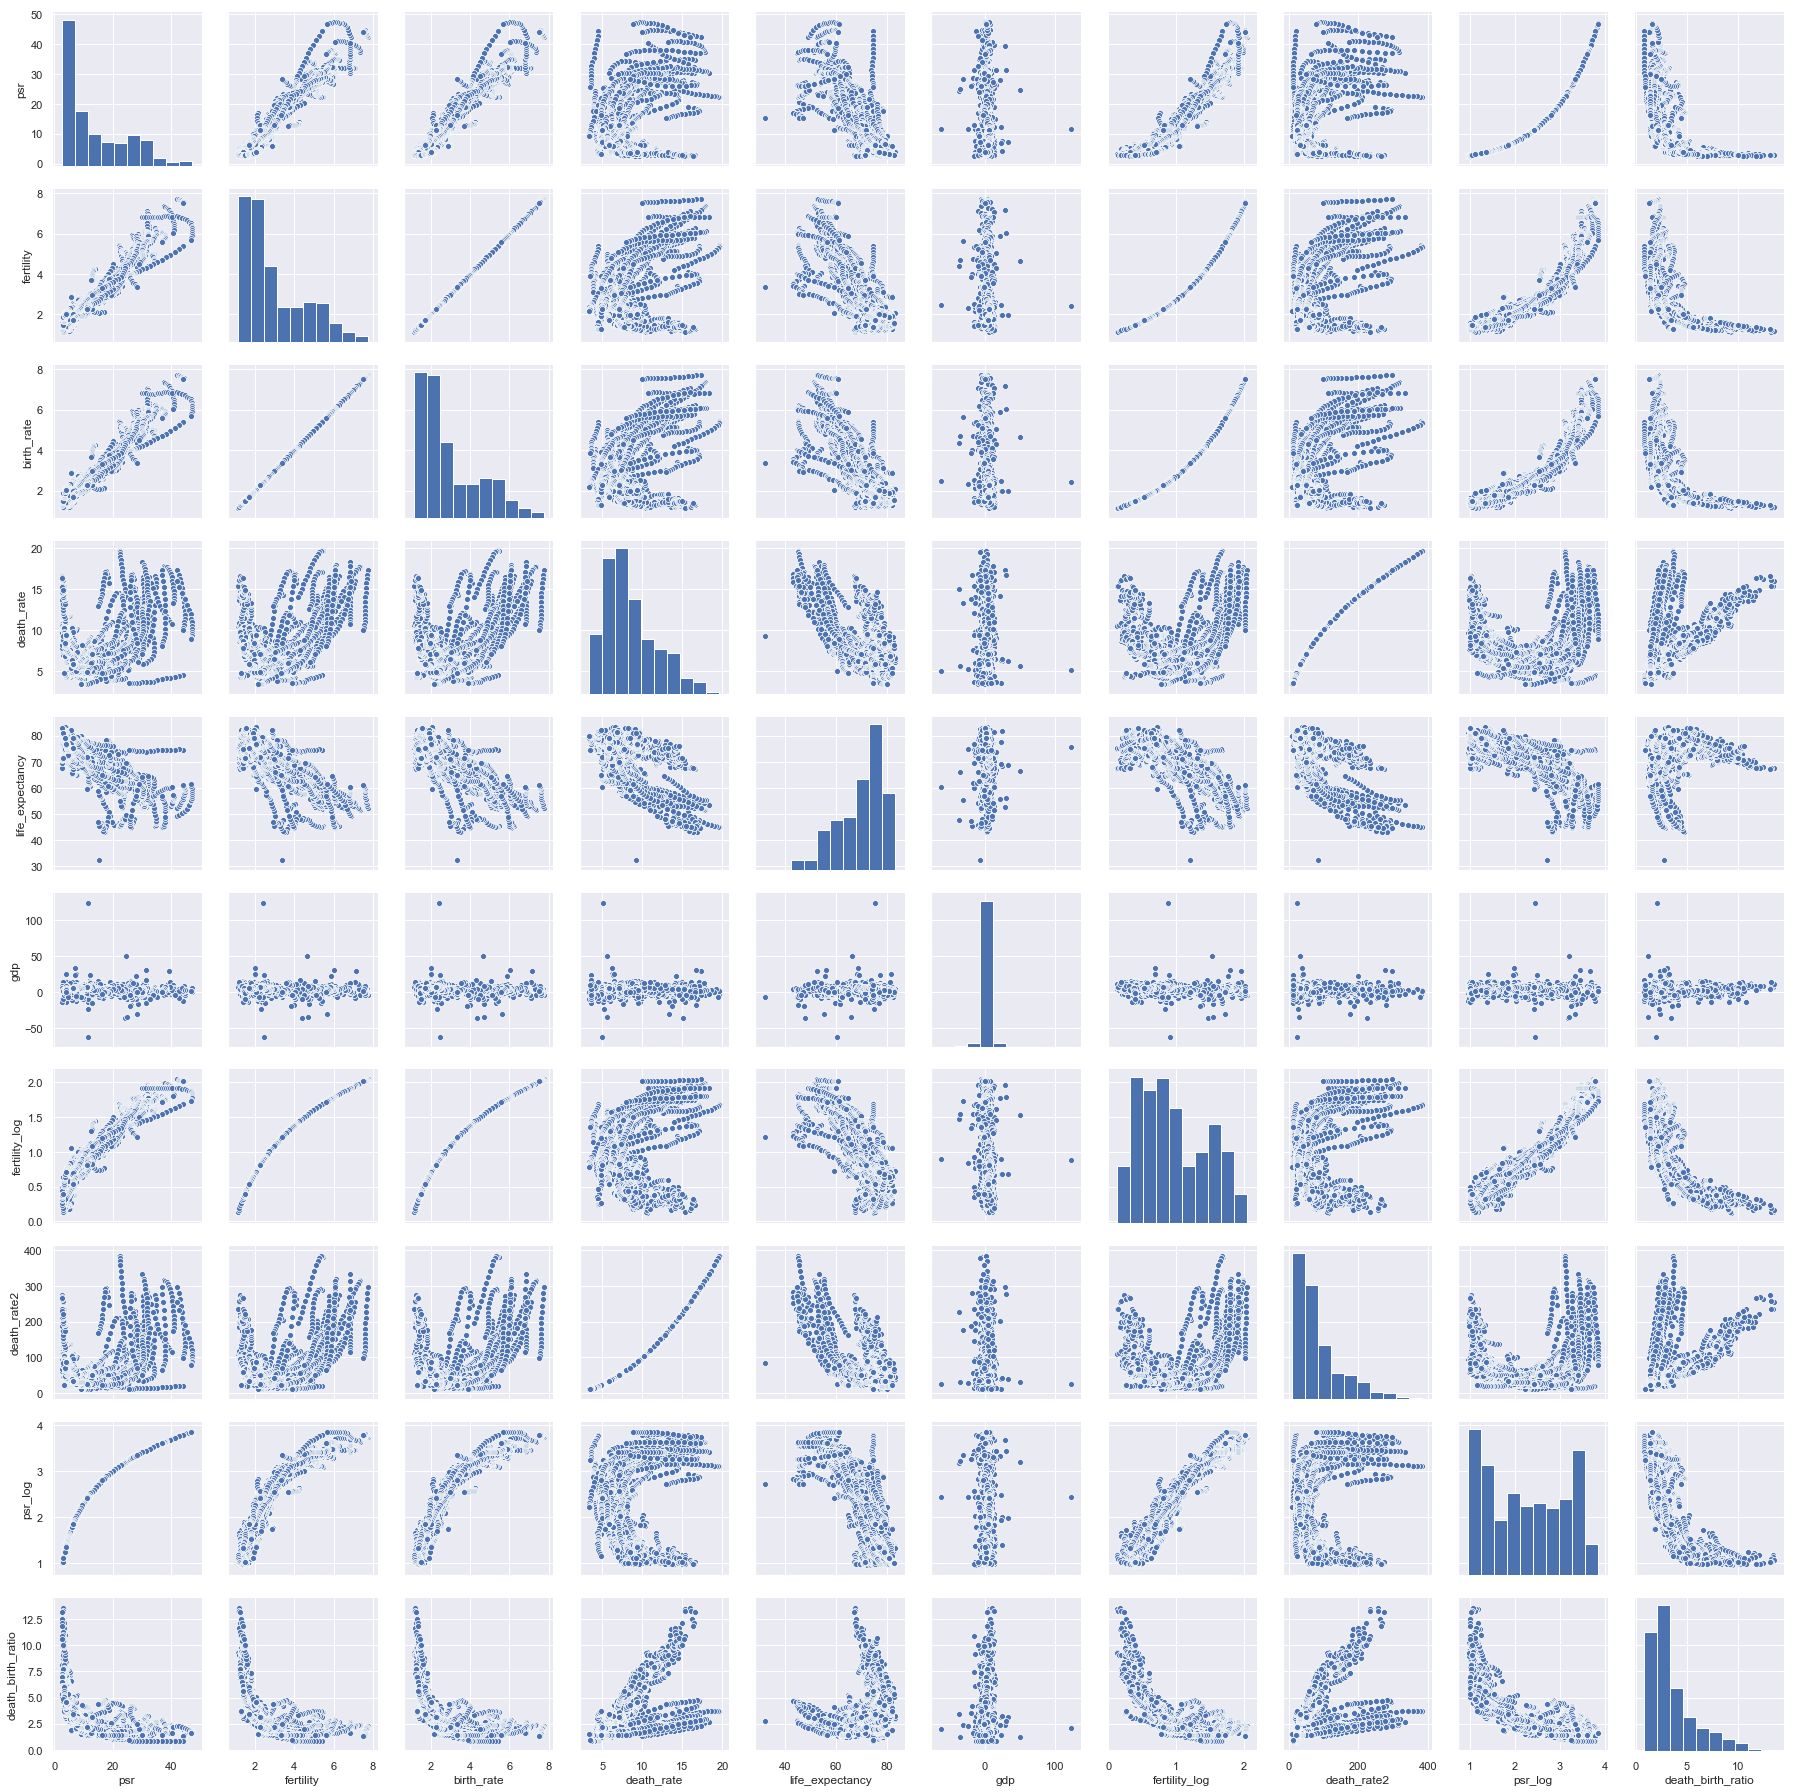

In [9]:
sns.pairplot(psr_data)

### Splitting Dataset to Train & Validate

Training and validation is done in the entire dataset, since test countries are in separate dataframe, notice that birth_rate is not included and both 'y' values will be used to find best psr model.

In [10]:
X = psr_data.loc[:,['fertility','death_rate','life_expectancy','gdp', 'fertility_log', 
                    'death_rate2', 'death_birth_ratio']]
y = psr_data[['psr', 'psr_log']]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25,random_state=42)

In [12]:
X_train.shape

(1560, 7)

In [13]:
X_val.shape

(520, 7)

### Model 1

Model 1 is comprised by original 'y' value ('psr') and original features. While designing this model life_expectancy was dropped because of collinearity, this was found through the application of Variance Inflator Factor (VIF). This feature is no longer considered for future models. 

In [14]:
X_train1 = sm.add_constant(X_train[['fertility','death_rate','gdp']])

model = sm.OLS(y_train['psr'], X_train1)
model_fit = model.fit()
predictions_model = model_fit.predict(X_train1)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    psr   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     6771.
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:56:22   Log-Likelihood:                -3888.1
No. Observations:                1560   AIC:                             7784.
Df Residuals:                    1556   BIC:                             7806.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7877      0.230    -25.132      0.000      -6.239      -5.336
fertility      6.9858      0.052    134.445      0.000       6.884       7.088
death_rate    -0.1508      0.025     -6.108      0.000      -0.199      -0.102
gdp            0.0361      0.013      2.680      0.007       0.010       0.063
==============================================================================
Omnibus:                      185.843   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              641.375
Skew:                           0.566   Prob(JB):                    5.34e-140
Kurtosis:                       5.930   Cond. No.                         31.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model 1 - Variance Inflator Factor

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train1.values, i) for i in range(X_train1.shape[1])]
vif['Features'] = X_train1.columns

In [19]:
vif.round(1)

,VIF Factor,Features
0,9.6,const
1,1.2,fertility
2,1.2,death_rate
3,1.0,gdp


#### Model 1 - Validation & RMSE

In [88]:
X_val1 = sm.add_constant(X_val[['fertility','death_rate','gdp']])

predictions_model1_val = model_fit.predict(X_val1)
r2_score(y_val['psr'], y_pred)

0.9366057026822818

In [89]:
mse = mean_squared_error(y_val['psr'], predictions_model1_val)
rmse = np.sqrt(mse)
rmse

2.8190223508967724

#### Model 1 - Plotting Predictions

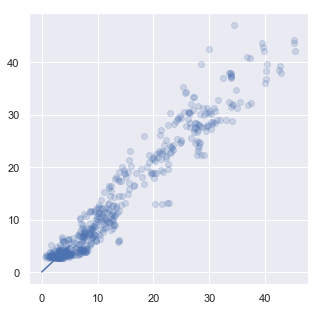

In [91]:
plt.figure(figsize=(5,5))
plt.scatter(predictions_model1_val,y_val['psr'],alpha=.2)
plt.plot([0,5],[0,5])

### Model 2 - Feature Engineering Y

Model 2 is comprised of original features but using the log of 'y' ('psr_log'), this decision was taken when observing the pairplot and skwedness of y. 

In [20]:
model2 = sm.OLS(y_train['psr_log'], X_train1)
model2_fit = model2.fit()
predictions_model2 = model2_fit.predict(X_train1)

model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                psr_log   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     3502.
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:56:22   Log-Likelihood:                -382.34
No. Observations:                1560   AIC:                             772.7
Df Residuals:                    1556   BIC:                             794.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1375      0.024     46.735      0.000       1.090       1.185
fertility      0.5560      0.005    101.252      0.000       0.545       0.567
death_rate    -0.0614      0.003    -23.537      0.000      -0.067      -0.056
gdp            0.0050      0.001      3.510      0.000       0.002       0.008
==============================================================================
Omnibus:                       40.533   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.042
Skew:                           0.332   Prob(JB):                     3.70e-11
Kurtosis:                       3.546   Cond. No.                         31.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model 2 - Validation & RMSE

In [83]:
predictions_model2_val = model2_fit.predict(X_val1)
r2_score(y_val['psr_log'], y2_pred)

0.9004085881737371

In [85]:
mse2 = mean_squared_error(y_val['psr_log'], predictions_model2_val)
rmse2 = np.sqrt(mse2)
rmse2

0.2780463269113927

#### Model 2 - Plotting Predictions

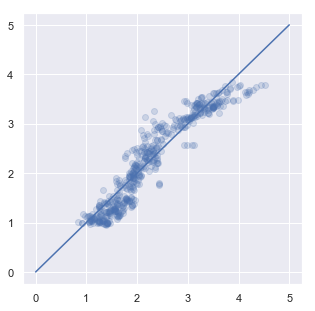

In [87]:
plt.figure(figsize=(5,5))
plt.scatter(predictions_model2_val,y_val['psr_log'],alpha=.2)
plt.plot([0,5],[0,5])

### Model 3 - Feature Engineering X

In [24]:
X_train2 = sm.add_constant(X_train[['fertility','gdp','death_birth_ratio', 'death_rate2']])
model3 = sm.OLS(y_train['psr'], X_train2)
model3_fit = model3.fit()
predictions_model3 = model3_fit.predict(X_train2)

model3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    psr   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     5159.
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:56:22   Log-Likelihood:                -3876.2
No. Observations:                1560   AIC:                             7762.
Df Residuals:                    1555   BIC:                             7789.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -8.4058      0.446    -18.834      0.000      -9.281      -7.530
fertility             7.4748      0.114     65.485      0.000       7.251       7.699
gdp                   0.0313      0.013      2.329      0.020       0.005       0.058
death_birth_ratio     0.3680      0.078      4.702      0.000       0.214       0.521
death_rate2          -0.0171      0.002     -7.288      0.000      -0.022      -0.012
==============================================================================
Omnibus:                      188.823   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              583.764
Skew:                           0.610   Prob(JB):                    1.73e-127
Kurtosis:                       5.737   Cond. No.                         677.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model 3 - Validation & RMSE

In [80]:
X_val2 = sm.add_constant(X_val[['fertility','gdp','death_birth_ratio', 'death_rate2']])
predictions_model3_val = model3_fit.predict(X_val2)

r2_score(y_val['psr'], y3_pred)

0.9389308285790302

In [81]:
mse3 = mean_squared_error(y_val['psr'], predictions_model3_val)
rmse3 = np.sqrt(mse3)
rmse3

2.7668424925053814

#### Model 3 - Plotting Predictions

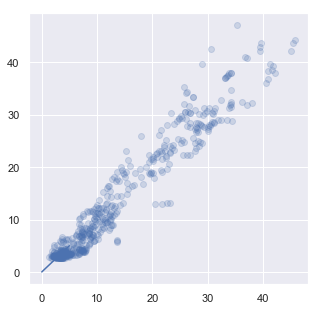

In [92]:
plt.figure(figsize=(5,5))
plt.scatter(predictions_model3_val,y_val['psr'],alpha=.2)
plt.plot([0,5],[0,5])

### Model 4 - Feature Engineering XY

In [28]:
X_train3 = sm.add_constant(X_train[['fertility_log','gdp','death_birth_ratio']])

model4 = sm.OLS(y_train['psr_log'], X_train3)
model4_fit = model4.fit()
predictions_model4 = model4_fit.predict(X_train3)

model4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                psr_log   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     5575.
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:56:23   Log-Likelihood:                -58.003
No. Observations:                1560   AIC:                             124.0
Df Residuals:                    1556   BIC:                             145.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.9627      0.031     31.111      0.000       0.902       1.023
fertility_log         1.5230      0.019     81.624      0.000       1.486       1.560
gdp                   0.0068      0.001      5.878      0.000       0.005       0.009
death_birth_ratio    -0.0491      0.004    -12.242      0.000      -0.057      -0.041
==============================================================================
Omnibus:                       12.609   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.791
Skew:                          -0.201   Prob(JB):                      0.00167
Kurtosis:                       3.188   Cond. No.                         37.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model 4 - Validation & RMSE

In [76]:
X_val3 = sm.add_constant(X_val[['fertility_log','gdp','death_birth_ratio']])
predictions_model4_val = model4_fit.predict(X_val3)

r2_score(y_val['psr_log'], y4_pred)

0.9209104594224745

In [77]:
mse4 = mean_squared_error(y_val['psr_log'], predictions_model4_val)
rmse4 = np.sqrt(mse4)
rmse4

0.24777971217895892

#### Model 4 - Plotting Predictions

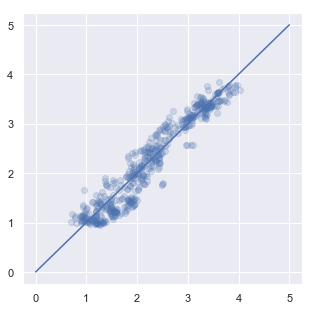

In [78]:
plt.figure(figsize=(5,5))
plt.scatter(predictions_model4_val,y_val['psr_log'],alpha=.2)
plt.plot([0,5],[0,5])

### Model 5 - LASSO (y)

In [32]:
alpha_array = np.arange(0.1, 1, 0.1)
param_grid = {'alpha': alpha_array, 'fit_intercept': [True, False]}

model5_lasso = GridSearchCV(Lasso(), param_grid, cv=5, n_jobs=-1, scoring='r2')
model5_lasso.fit(X_train, y_train['psr'])

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [33]:
model5_lasso.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
model5_lasso.best_estimator_.score(X_train, y_train['psr'])

0.9510288809400521

#### Model 5 - Validation & RMSE

In [37]:
model5_lasso.best_estimator_.score(X_val, y_val['psr'])

0.9541032904679203

In [38]:
mse5 = mean_squared_error(y_val['psr'], predictions_model5_val)
rmse5 = np.sqrt(mse5)
rmse5

2.3986351768160152

#### Model 5 - Plotting Predictions

In [35]:
predictions_model5 = model5_lasso.best_estimator_.predict(X_train)
predictions_model5_val = model5_lasso.best_estimator_.predict(X_val)

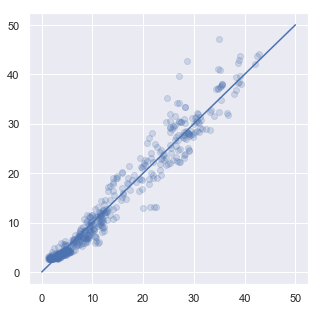

In [75]:
plt.figure(figsize=(5,5))
plt.scatter(predictions_model5_val,y_val['psr'],alpha=.2)
plt.plot([0,50],[0,50])

### Model 6 - LASSO (y_log)

#### Grid Search

In [39]:
alpha_array = np.arange(0.1, 1, 0.1)
param_grid = {'alpha': alpha_array, 'fit_intercept': [True, False]}

In [40]:
model6_lasso = GridSearchCV(Lasso(), param_grid, cv=5, n_jobs=-1, scoring='r2')
model6_lasso.fit(X_train, y_train['psr_log'])

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [41]:
model6_lasso.best_estimator_

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
model6_lasso.best_estimator_.score(X_train, y_train['psr_log'])

0.9385909659349573

In [43]:
model6_lasso.best_estimator_.coef_

array([ 0.16507417, -0.        , -0.05615592,  0.        ,  0.        ,
       -0.00258513, -0.0994689 ])

#### Model 6 - Validation & RMSE

In [46]:
model6_lasso.best_estimator_.score(X_val, y_val['psr_log'])

0.9397564699111602

In [47]:
mse6 = mean_squared_error(y_val['psr_log'], predictions_model6_val)
rmse6 = np.sqrt(mse6)
rmse6

0.21625264292426155

#### Model 6 - Plotting Predictions

In [44]:
predictions_model6 = model6_lasso.best_estimator_.predict(X_train)
predictions_model6_val = model6_lasso.best_estimator_.predict(X_val)

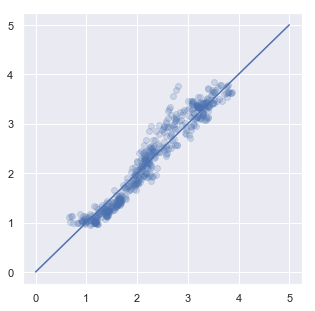

In [74]:
plt.figure(figsize=(5,5))
plt.scatter(predictions_model6_val,y_val['psr_log'],alpha=.2)
plt.plot([0,5],[0,5])

### Model 7 - Ridge on Model 2

In [48]:
ridge_model_1 = Ridge(alpha = 0.1)
ridge_model_1.fit(X_train1, y_train['psr_log'])

list(zip(X_train1.columns, ridge_model_1.coef_))

[('const', 0.0),
 ('fertility', 0.5560252617165975),
 ('death_rate', -0.061396473228869985),
 ('gdp', 0.005003715214533023)]

In [49]:
prediction_ridge1_train = ridge_model_1.predict(X_train1)
r2_score(y_train['psr_log'], prediction_ridge1_train)

0.8709995681274644

#### Model 7 - Validation & RMSE

In [51]:
prediction_ridge1_val = ridge_model_1.predict(X_val1)
r2_score(y_val['psr_log'], prediction_ridge1_val)

0.9004072339526104

In [52]:
mse7 = mean_squared_error(y_val['psr_log'],prediction_ridge1_val)
rmse7 = np.sqrt(mse7)
rmse7

0.2780482173099884

#### Model 7 - Plotting Predictions

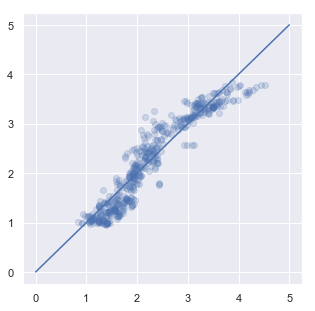

In [73]:
plt.figure(figsize=(5,5))
plt.scatter(prediction_ridge1_val,y_val['psr_log'],alpha=.2)
plt.plot([0,5],[0,5])

### Model 8 - Ridge on Model 4

In [53]:
ridge_model_2 = Ridge(alpha = 0.1)
ridge_model_2.fit(X_train3, y_train['psr_log'])

list(zip(X_train2.columns, ridge_model_2.coef_))

[('const', 0.0),
 ('fertility', 1.5221409051313766),
 ('gdp', 0.006810687741191669),
 ('death_birth_ratio', -0.04927027949986334)]

In [54]:
prediction_ridge2_train = ridge_model_2.predict(X_train3)
r2_score(y_train['psr_log'], prediction_ridge2_train)

0.9148853745890826

#### Model 8 - Validation & RMSE

In [56]:
prediction_ridge2_val = ridge_model_2.predict(X_val3)
r2_score(y_val['psr_log'], prediction_ridge2_val)

0.9209108396574499

In [57]:
mse8 = mean_squared_error(y_val['psr_log'],prediction_ridge2_val)
rmse8 = np.sqrt(mse6)
rmse8 

0.21625264292426155

#### Model 8 - Plotting Predictions

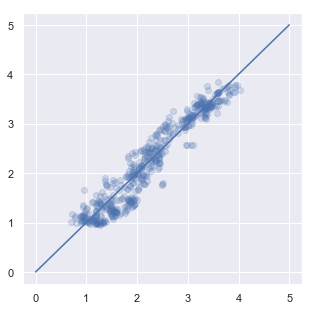

In [71]:
plt.figure(figsize=(5,5))
plt.scatter(prediction_ridge2_val,y_val['psr_log'],alpha=.2)
plt.plot([0,5],[0,5])

### Model 9 - Random Forest (y_log)

In [58]:
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(X_train, y_train['psr_log'])
regr.score(X_train, y_train['psr_log'])

0.9203702104307434

#### Model 9 - Validation & RMSE

In [61]:
regr.score(X_val, y_val['psr_log'])

0.9222267113151738

In [62]:
mse2 = mean_squared_error(y_val['psr_log'], prediction_rf_val)
rmse = np.sqrt(mse2)
rmse

0.2457092179272778

#### Model 9 - Plotting Predictions

In [59]:
prediction_rf = regr.predict(X_train)
prediction_rf_val = regr.predict(X_val)

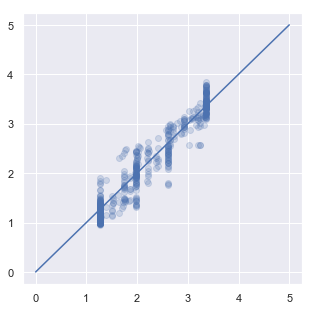

In [72]:
plt.figure(figsize=(5,5))
plt.scatter(prediction_rf_val,y_val['psr_log'],alpha=.2)
plt.plot([0,5],[0,5])

## Testing Best Model (Model 6 - LASSO(y_log))

#### Opening & Adding Engineered Features

In [63]:
psr_data_test = pd.read_pickle("psr_data_test.pkl")

In [64]:
psr_data_test['fertility_log'] = np.log(psr_data_test.fertility)
psr_data_test['death_rate2'] = psr_data_test.death_rate ** 2
psr_data_test['psr_log'] = np.log(psr_data_test.psr)
psr_data_test['death_birth_ratio'] =  psr_data_test.death_rate/psr_data_test.birth_rate

In [65]:
psr_data_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 528 entries, (Angola, 2000) to (United Arab Emirates, 2015)
Data columns (total 10 columns):
psr                  528 non-null float64
fertility            528 non-null float64
birth_rate           528 non-null float64
death_rate           528 non-null float64
life_expectancy      528 non-null float64
gdp                  528 non-null float64
fertility_log        528 non-null float64
death_rate2          528 non-null float64
psr_log              528 non-null float64
death_birth_ratio    528 non-null float64
dtypes: float64(10)
memory usage: 55.4+ KB


#### Defining X and y values

In [66]:
X_test = psr_data_test.loc[:,['fertility','death_rate','life_expectancy','gdp', 'fertility_log', 
                    'death_rate2', 'death_birth_ratio']]
y_test = psr_data_test['psr_log']

#### Running Model 6 on Test

In [67]:
final_model = GridSearchCV(Lasso(), param_grid, cv=5, n_jobs=-1, scoring='r2')
final_model.fit(X_test, y_test)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [68]:
final_model.best_estimator_.score(X_test, y_test)

0.937304417192076

In [69]:
predictions_final_model = final_model.best_estimator_.predict(X_test)

In [70]:
mse_final = mean_squared_error(y_test, predictions_final_model)
rmse_final = np.sqrt(mse_final)
rmse_final

0.2394379906647499